In [30]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5' 
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as random
from progressbar import ProgressBar
from sklearn.preprocessing import MinMaxScaler
import scipy
import pickle

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
import official.nlp.modeling.layers as nlp_layers


from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse
from sklearn.model_selection import train_test_split
import official.nlp.modeling.layers as nlp_layers

plt.rcParams.update({'font.size': 18})

In [31]:
def math_fun(x):
    x1=x[:,0]
    x2=x[:,1]
    g=((1.5+x1)**2+4)*(1.5+x2)/20-np.sin(5*(1.5+x1)/2)
    return g

### Prepare the training, testing and OOD data for the ML model
def make_data():
    mean_c1 = (8, 3.5)
    cov_c1 = [[0.4, -0.32], [-0.32, 0.4]]
    c1_sample_no = 500
    x_c1 = np.random.multivariate_normal(mean_c1, cov_c1, (c1_sample_no, 1)).reshape(c1_sample_no, 2)

    mean_c2 = (-2.5, -2.5)
    cov_c2 = [[0.4, -0.32], [-0.32, 0.4]]
    c2_sample_no = 500
    x_c2 = np.random.multivariate_normal(mean_c2, cov_c2, (c2_sample_no, 1)).reshape(c2_sample_no, 2)

    mean_ood = (-10, -7.5)
    cov_ood = [[0.2, -0.16], [-0.16, 0.2]]
    ood_sample_no = 200
    x_ood = np.random.multivariate_normal(mean_ood, cov_ood, (ood_sample_no, 1)).reshape(ood_sample_no, 2) 

    y_c1 = math_fun(x_c1).reshape(-1, 1)
    y_c2 = math_fun(x_c2).reshape(-1, 1)
    y_ood = math_fun(x_ood).reshape(-1, 1)

    ## Create train and test data for each cluster of data
    random_state = 1
    x_c1_train, x_c1_test, y_c1_train, y_c1_test = train_test_split(x_c1, y_c1, test_size=0.2, random_state=random_state)
    x_c2_train, x_c2_test, y_c2_train, y_c2_test = train_test_split(x_c2, y_c2, test_size=0.2, random_state=random_state)

    x_train = np.concatenate((x_c1_train, x_c2_train), axis = 0)
    x_test = np.concatenate((x_c1_test, x_c2_test), axis = 0)
    y_train = np.concatenate((y_c1_train, y_c2_train), axis = 0)
    y_test = np.concatenate((y_c1_test, y_c2_test), axis = 0)

    plt.figure(figsize=(10, 10))
    plt.scatter(x_c1_train[:, 0], x_c1_train[:, 1], color = 'red', marker = '+', label='1st cluster train')
    plt.scatter(x_c1_test[:, 0], x_c1_test[:, 1], color = 'red', marker = 's', label='1st cluster test')

    plt.scatter(x_c2_train[:, 0], x_c2_train[:, 1], color = 'blue', marker = '+', label='2nd cluster train')
    plt.scatter(x_c2_test[:, 0], x_c2_test[:, 1], color = 'blue', marker = 's', label='2nd cluster test')

    plt.scatter(x_ood[:, 0], x_ood[:, 1], color = 'purple', label = 'OOD samples')

    plt.xlabel('X1', fontsize=22, fontweight='bold')
    plt.ylabel('X2', fontsize=22, fontweight='bold')
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18, fontweight='bold')

    plt.legend(fontsize=20)
    plt.axis('equal')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.tight_layout()
    plt.savefig('train_test_data.pdf')

    n_meshes = 150
    x1, x2 = np.meshgrid(np.linspace(-15, 15, n_meshes), np.linspace(-15, 15, n_meshes))
    x_mesh = np.concatenate((x1.reshape(-1, 1), x2.reshape(-1, 1)), axis = 1)
    y_mesh = math_fun(x_mesh).reshape(-1, 1).flatten()

    return x_train, x_test, y_train, y_test, x_ood, y_ood, x_mesh, y_mesh

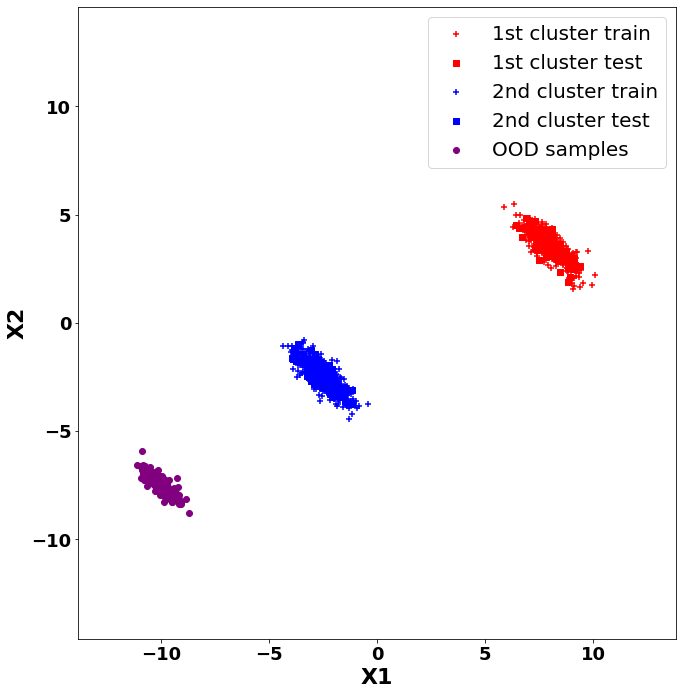

In [32]:
np.random.seed(1)
x_train, x_test, y_train, y_test, x_ood, y_ood, x_mesh, y_mesh = make_data()

In [33]:
scalerX, scalerY = MinMaxScaler(), MinMaxScaler()
x_train_norm, y_train_norm = scalerX.fit_transform(x_train), scalerY.fit_transform(y_train)
x_test_norm, y_test_norm = scalerX.transform(x_test), scalerY.transform(y_test)
x_ood_norm, y_ood_norm   = scalerX.transform(x_ood), scalerY.transform(y_ood)
x_mesh_norm = scalerX.transform(x_mesh)
y_mesh_norm = scalerY.transform(y_mesh.reshape(-1, 1))

## Common function definitions

In [34]:
def plot_uncertainty_map(x_train, x_ood, x_mesh, output_std, filename, spectral_normalization = False, contour=False):
    """
    Input
    x_train, x_ood: training and OOD data
    x_mesh: input mesh spanning across the input range
    output_std: 
    """
    std_scaled = output_std/max(output_std)
    plt.figure(figsize=(10, 10))
    plt.rcParams['axes.xmargin'] = 0
    plt.rcParams['axes.ymargin'] = 0
    plt.scatter(x_mesh[:, 0], x_mesh[:, 1], rasterized = True, c = std_scaled, cmap = plt.get_cmap('viridis'))
    
    if spectral_normalization:
        cbar = plt.colorbar(fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=28)
        
    plt.scatter(x_train[:, 0], x_train[:, 1], color = 'magenta', s = 20, alpha = 0.7, label = 'Training')
    plt.scatter(x_ood[:, 0], x_ood[:, 1], color = 'red', s = 20, alpha = 0.7, label = 'OOD')

    if contour:
        n = np.ceil(np.sqrt(len(std_scaled))).astype(int)
        h = std_scaled.reshape(n, n)
        contours = plt.contour(x_mesh[:, 0].reshape(n, n), x_mesh[:, 1].reshape(n, n), h)
        plt.clabel(contours, inline=True, fontsize=12)

        filename += '_with_contour'

    plt.legend(fontsize=20, loc=4)
    plt.xlabel(r'$x_1$', fontsize=40, fontweight='bold')
    plt.ylabel(r'$x_2$', fontsize=40, fontweight='bold')
    plt.xticks(fontsize=36, fontweight='bold')
    plt.yticks(fontsize=36, fontweight='bold')

    plt.tight_layout()
    ax = plt.gca()
    ax.set_aspect('equal')

def get_rmse(y_true, y_pred):
    """
    Inputs:
    y_true - true values
    y_pred - predicted values
    Outputs:
    root mean squarred error
    """
    return np.sqrt(np.mean((y_true-y_pred)**2))

# UQ model training

Each of the model has the following sequence:
- model functions/class definitions
- a single end-to-end run

## Uncertainty Model: SNGP

distance-aware based

 - spectral normalization from keras layers
 - gaussian process from gpflow, gpflux libraries

(inspiration from https://secondmind-labs.github.io/GPflux/notebooks/gpflux_with_keras_layers.html and https://www.tensorflow.org/tutorials/understanding/sngp)

In [35]:
class RN_SNGP(tf.keras.Model):
    def __init__(self, no_outputs, spec_norm_bound=0.9, actfn = 'relu', num_layers=2, **kwargs):
        """
        Inputs: 
        no_ouputs - number of outputs
        spec_norm_bound - spectral normalization multiplier
        actfn - activation function
        """
        super().__init__()
        self.actfn = actfn
        self.spec_norm_bound = spec_norm_bound
        self.num_layers = num_layers
        self.kwargs = kwargs

        # hidden layers.
        self.dense_layers1 = nlp_layers.SpectralNormalization(self.make_dense_layer(100),
                                                              norm_multiplier=self.spec_norm_bound)
        self.dense_layers2 = nlp_layers.SpectralNormalization(self.make_dense_layer(100),
                                                              norm_multiplier=self.spec_norm_bound)
        self.dense_layers3 = nlp_layers.SpectralNormalization(self.make_dense_layer(10),
                                                              norm_multiplier=self.spec_norm_bound)
        # output layer.
        self.regressor = self.make_output_layer(no_outputs)

    def call(self, inputs, training=True, return_covmat=False):
        x = self.dense_layers1(inputs)
        for _ in range(self.num_layers):
            x = self.dense_layers2(x)
            x1 = self.dense_layers2(x)
            x = x1 + x
        x = self.dense_layers3(x)
        mean = self.regressor(x)[0]
        variance = self.regressor(x)[1]
        if not training and return_covmat:
            return mean, variance
        
        return mean

    def make_dense_layer(self, hidden_units):
        """Use the Dense layer as the hidden layer."""
        return tf.keras.layers.Dense(hidden_units, activation=self.actfn)

    def make_output_layer(self, no_outputs):
        """Uses Gaussian process as the output layer."""
        return nlp_layers.RandomFeatureGaussianProcess(
            no_outputs,
            gp_cov_momentum=-1,
            **self.kwargs)

class ResetCovarianceCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        """Resets covariance matrix at the beginning of the epoch."""
        if epoch > 0:
            self.model.regressor.reset_covariance_matrix()

class RN_SNGPWithCovReset(RN_SNGP):
    def fit(self, *args, **kwargs):
        """Adds ResetCovarianceCallback to model callbacks."""
        kwargs["callbacks"] = list(kwargs.get("callbacks", []))
        kwargs["callbacks"].append(ResetCovarianceCallback())
        return super().fit(*args, **kwargs)

In [36]:
def generate_trained_SNGPmodel(trainX, trainY, nepochs, actfn = 'relu', spec_norm_bound = 0.9, num_layers=2):
    """
    Inputs:
    trainX  - training input of shape (samples, num of features)
    trainY  - training output of shape (samples, 1)
    nepochs - number of epochs
    actfn   - activation function
    spec_norm_bound - spectral normalization bounds
    Outputs:
    model   - trained SNGP model
    """
    loss = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=3e-4)

    model = RN_SNGPWithCovReset(no_outputs=1, spec_norm_bound = spec_norm_bound, actfn=actfn, 
                                num_layers = num_layers)
    model.compile(loss=loss, optimizer=optimizer)
    model.fit(trainX, trainY, epochs=nepochs, verbose=0)
    return model

ResNet block :1, epochs: 100


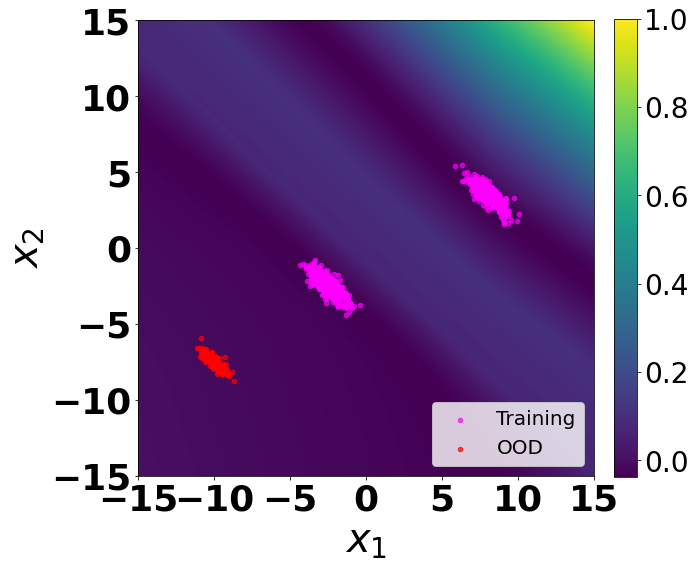

ResNet block :1, epochs: 500


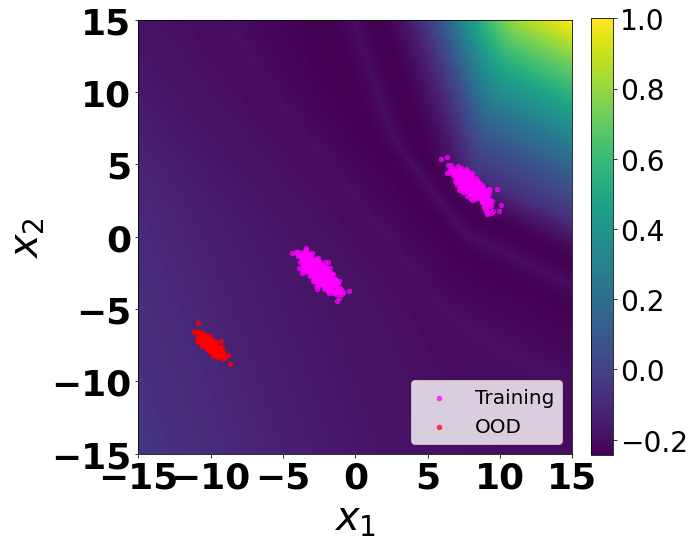

ResNet block :1, epochs: 1000


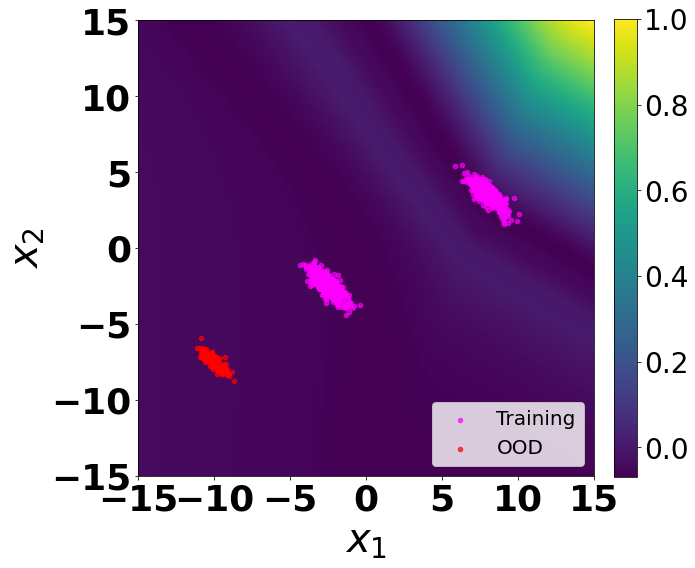

ResNet block :1, epochs: 5000


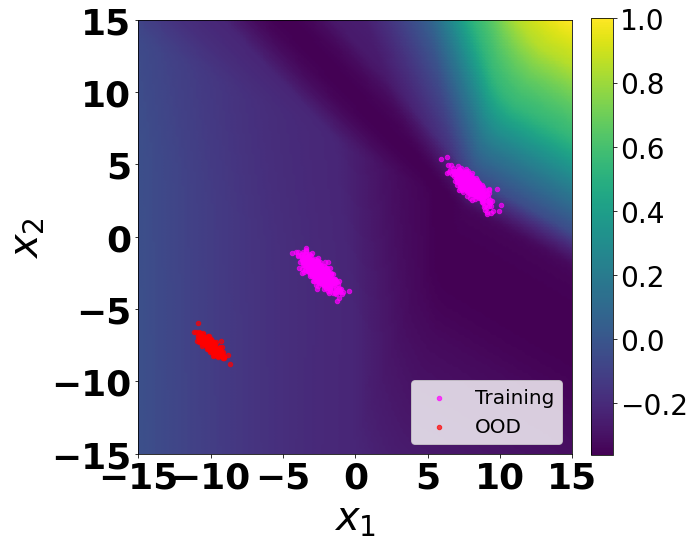

ResNet block :2, epochs: 100


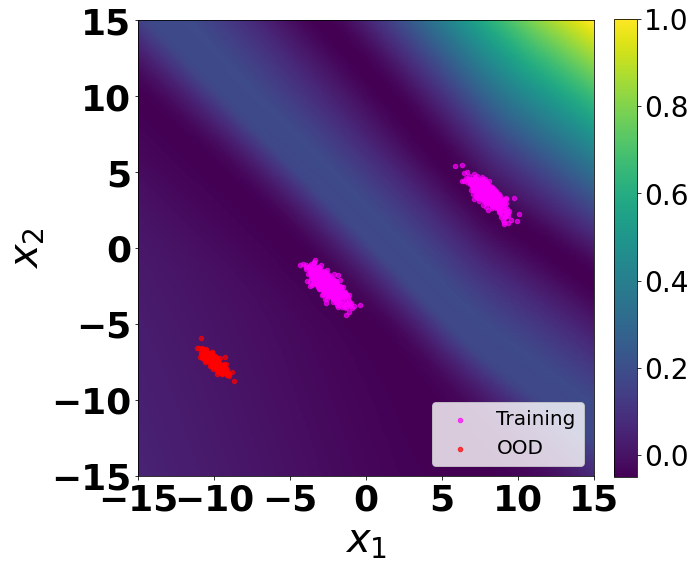

ResNet block :2, epochs: 500


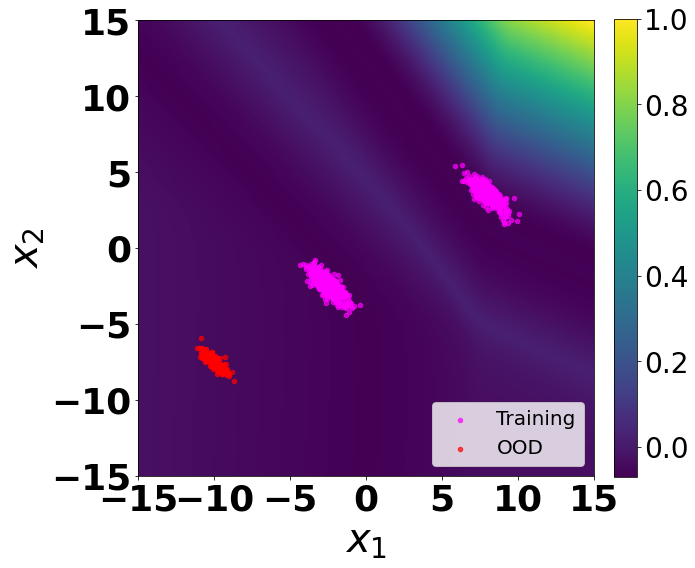

ResNet block :2, epochs: 1000


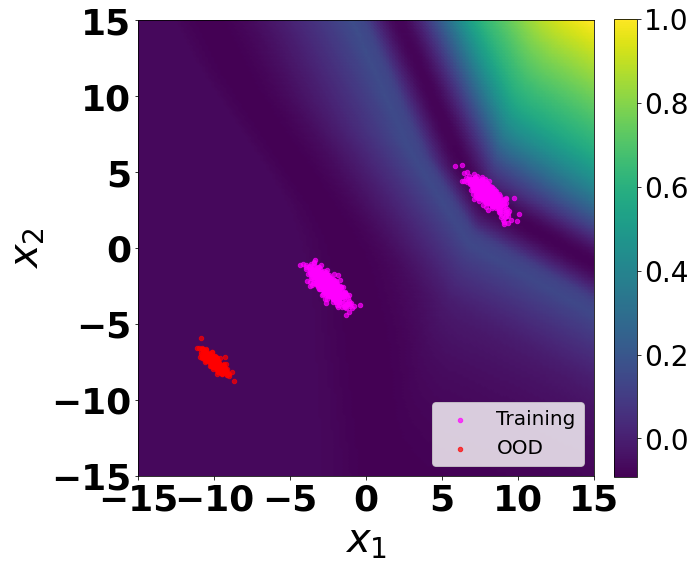

KeyboardInterrupt: 

In [37]:
# single run
for num_layers in [1,2,3]:
    for epoch in [100, 500, 1000, 5000]:
        model_SNGP = generate_trained_SNGPmodel(x_train_norm, y_train_norm, epoch, 'relu', 0.9, num_layers = 1)

        result_df = pd.DataFrame(x_mesh, columns = ['x1', 'x2'])
        result_df["SNGP_mu_eff"] = scalerY.inverse_transform(
                                    model_SNGP(x_mesh_norm, training=False, return_covmat=True)[0])
        result_df["SNGP_sigma_eff"] = scalerY.inverse_transform(
                                    np.sqrt(tf.linalg.diag_part(
                                            model_SNGP(x_mesh_norm, training=False, return_covmat=True)[1])[:, None]
                                             ))
        print(f'ResNet block :{num_layers}, epochs: {epoch}')
        plot_uncertainty_map(x_train, x_ood, x_mesh, result_df['SNGP_sigma_eff'],'SNGP', True, False)
        plt.show()

## Uncertainty Model: DNNGP

SNGP but without spectral normalization wrapper?

In [28]:
class RN_DNNGP(tf.keras.Model):
    def __init__(self, no_outputs, actfn = 'relu', num_layers=2, **kwargs):
        """
        Inputs: 
        no_ouputs - number of outputs
        spec_norm_bound - spectral normalization multiplier
        actfn - activation function
        """
        super().__init__()
        self.actfn = actfn
        self.num_layers = num_layers
        self.kwargs = kwargs

        # hidden layers.
        self.dense_layers1 = self.make_dense_layer(100)
        self.dense_layers2 = self.make_dense_layer(100)
        self.dense_layers3 = self.make_dense_layer(10)
        # output layer.
        self.regressor = self.make_output_layer(no_outputs)

    def call(self, inputs, training=True, return_covmat=False):
        x = self.dense_layers1(inputs)
        for _ in range(self.num_layers):
            x = self.dense_layers2(x)
            x1 = self.dense_layers2(x)
            x = x1 + x
        x = self.dense_layers3(x)
        mean = self.regressor(x)[0]
        variance = self.regressor(x)[1]
        if not training and return_covmat:
            return mean, variance
        
        return mean

    def make_dense_layer(self, hidden_units):
        """Use the Dense layer as the hidden layer."""
        return tf.keras.layers.Dense(hidden_units, activation=self.actfn)

    def make_output_layer(self, no_outputs):
        """Uses Gaussian process as the output layer."""
        return nlp_layers.RandomFeatureGaussianProcess(
            no_outputs,
            gp_cov_momentum=-1,
            **self.kwargs)

class ResetCovarianceCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        """Resets covariance matrix at the beginning of the epoch."""
        if epoch > 0:
            self.model.regressor.reset_covariance_matrix()

class RN_DNNGPWithCovReset(RN_DNNGP):
    def fit(self, *args, **kwargs):
        """Adds ResetCovarianceCallback to model callbacks."""
        kwargs["callbacks"] = list(kwargs.get("callbacks", []))
        kwargs["callbacks"].append(ResetCovarianceCallback())
        return super().fit(*args, **kwargs)
    
def generate_trained_DNNGPmodel(trainX, trainY, nepochs, actfn = 'relu', num_layers=2):
    """
    Inputs:
    trainX  - training input of shape (samples, num of features)
    trainY  - training output of shape (samples, 1)
    nepochs - number of epochs
    actfn   - activation function
    spec_norm_bound - spectral normalization bounds
    Outputs:
    model   - trained SNGP model
    """
    loss = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=3e-4)

    model = RN_DNNGPWithCovReset(no_outputs=1, actfn=actfn,num_layers = num_layers)
    model.compile(loss=loss, optimizer=optimizer)
    model.fit(trainX, trainY, epochs=nepochs, verbose=0)
    return model


ResNet block :1, epochs: 100


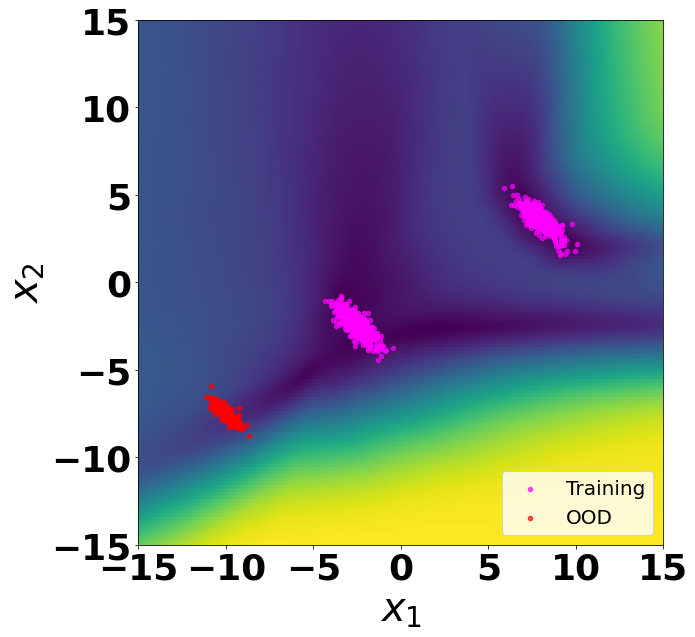

ResNet block :1, epochs: 500


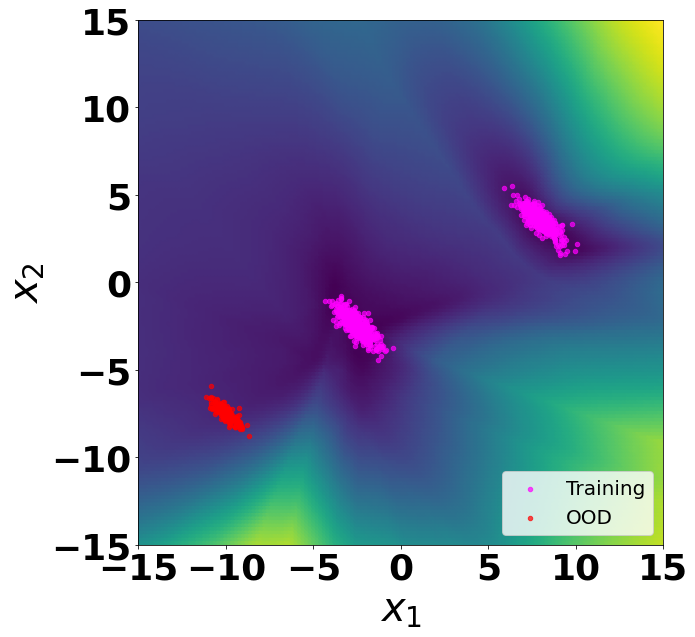

ResNet block :1, epochs: 1000


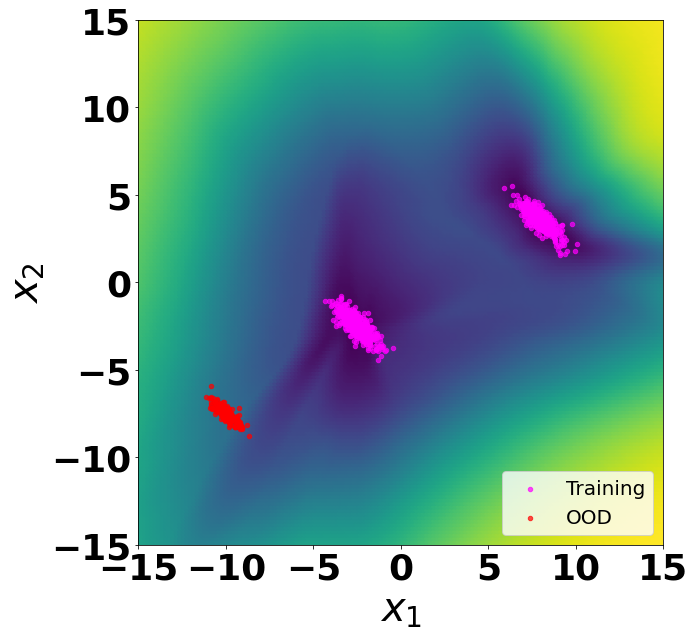

ResNet block :1, epochs: 5000


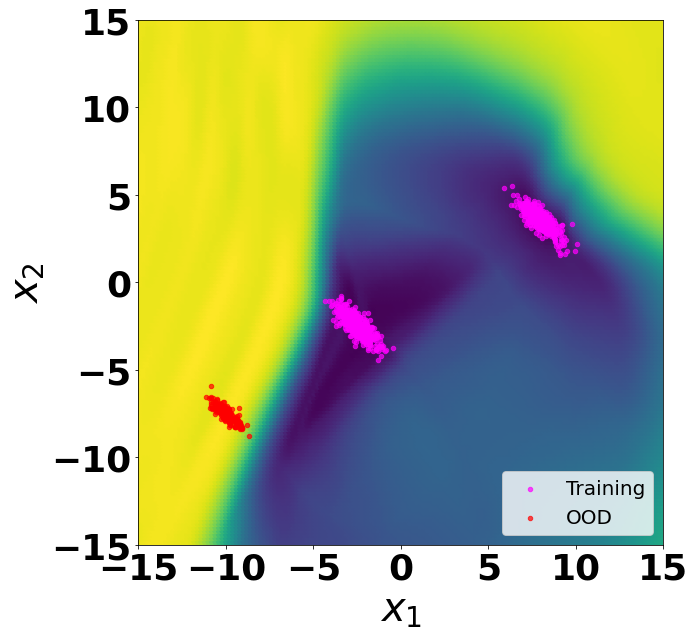

ResNet block :2, epochs: 100


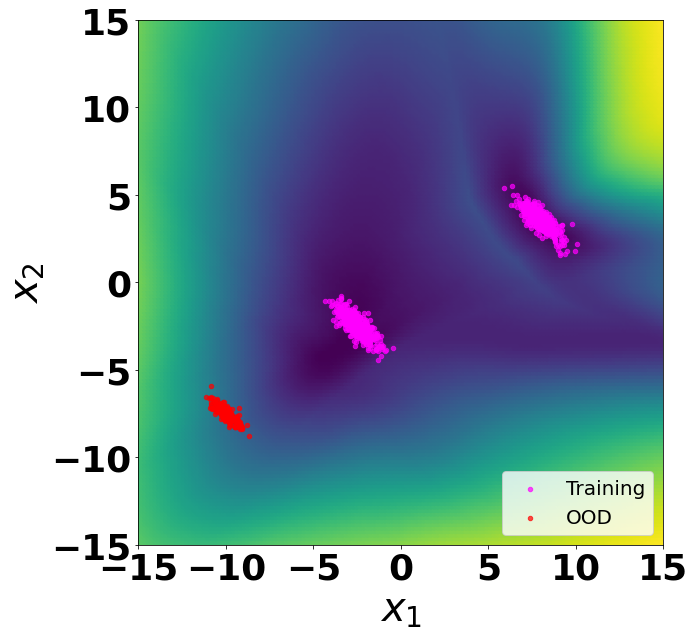

ResNet block :2, epochs: 500


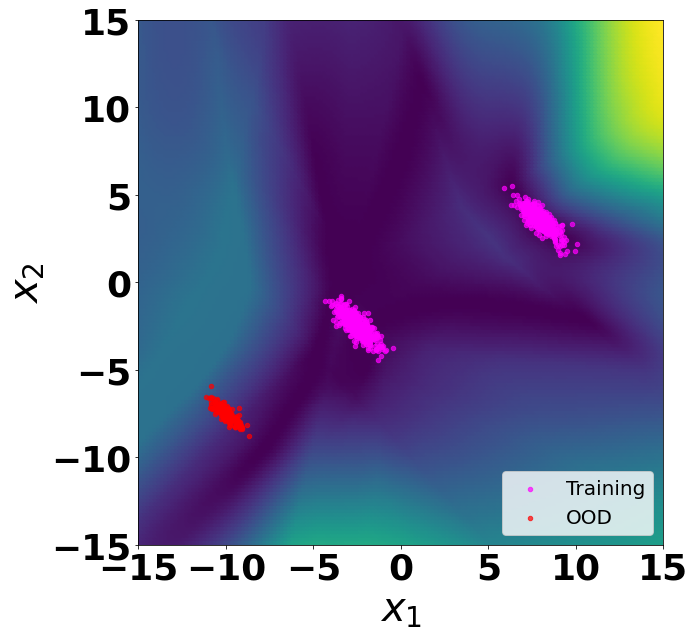

ResNet block :2, epochs: 1000


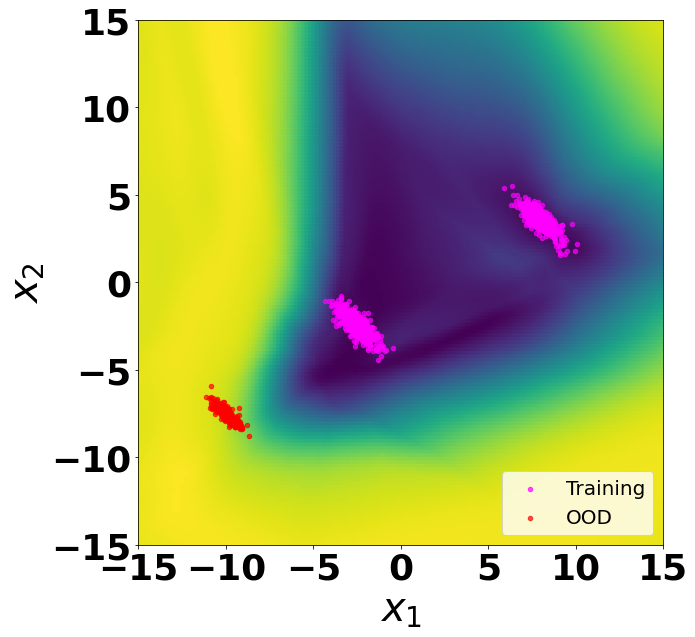

ResNet block :2, epochs: 5000


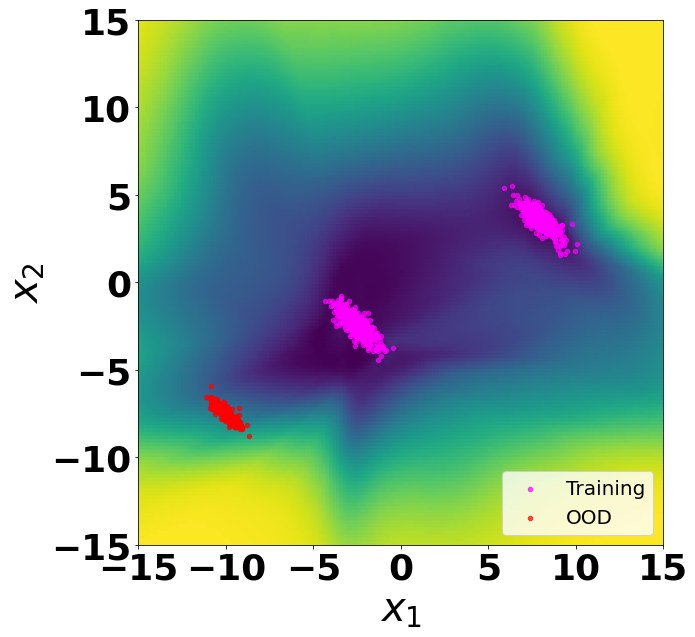

ResNet block :3, epochs: 100


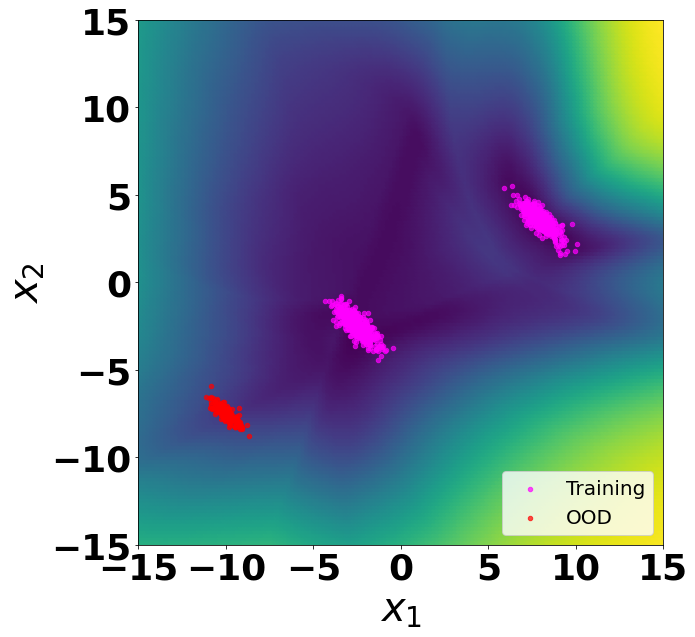

ResNet block :3, epochs: 500


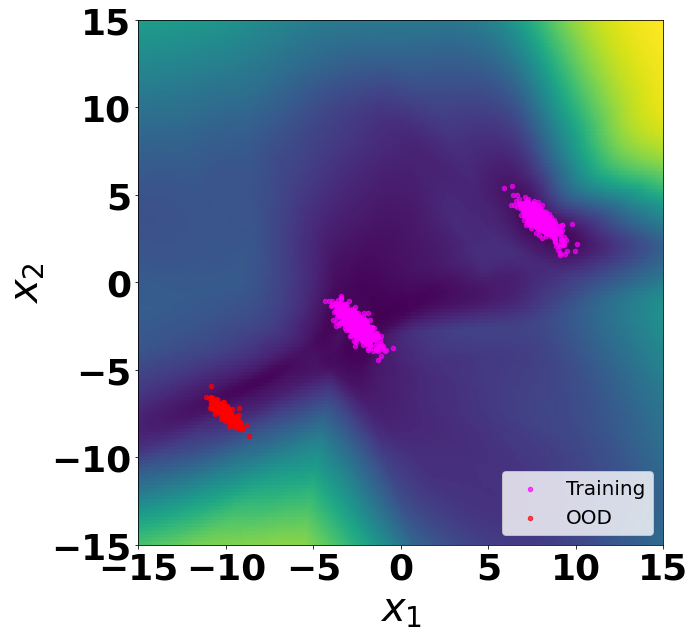

ResNet block :3, epochs: 1000


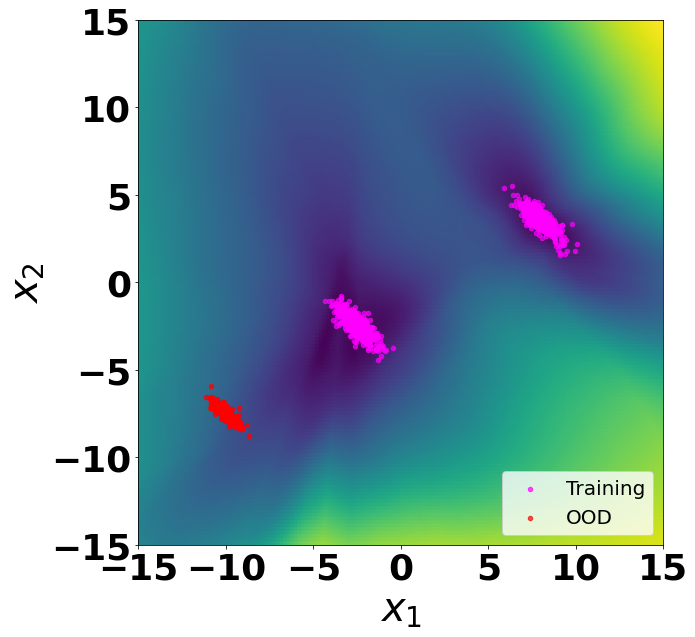

ResNet block :3, epochs: 5000


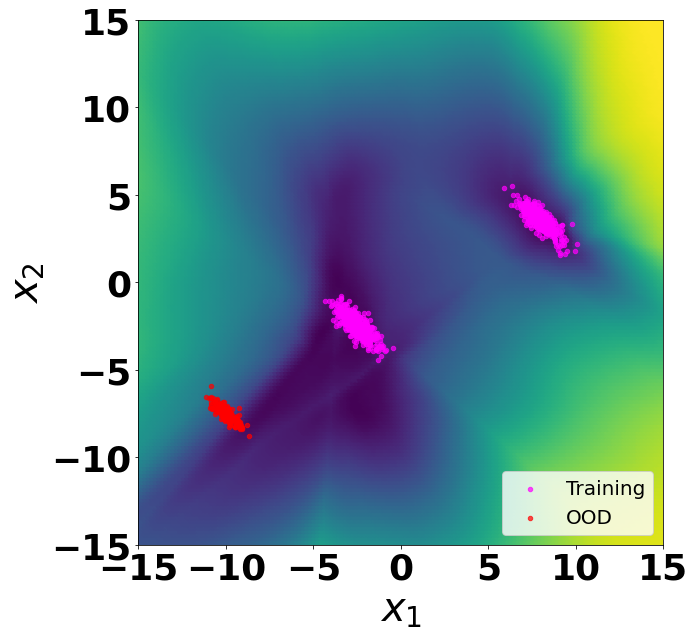

In [29]:
# single run
for num_layers in [1,2,3]:
    for epoch in [100, 500, 1000, 5000]:
        model_DNNGP = generate_trained_DNNGPmodel(x_train_norm, y_train_norm, epoch, 'relu', num_layers = 1)

        result_df = pd.DataFrame(x_mesh, columns = ['x1', 'x2'])
        result_df["DNNGP_mu_eff"] = scalerY.inverse_transform(
                                    model_DNNGP(x_mesh_norm, training=False, return_covmat=True)[0])
        result_df["DNNGP_sigma_eff"] = scalerY.inverse_transform(
                                    np.sqrt(tf.linalg.diag_part(
                                            model_DNNGP(x_mesh_norm, training=False, return_covmat=True)[1])[:, None]
                                             ))
        print(f'ResNet block :{num_layers}, epochs: {epoch}')
        plot_uncertainty_map(x_train, x_ood, x_mesh, result_df['DNNGP_sigma_eff'],'DNNGP', False, False)
        plt.show()